In [16]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import timedelta
import sys
sys.path.append('../../lib/')
from analysis import *
import pickle as pkl

In [17]:
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, TimeDistributed, \
    Input, BatchNormalization, multiply, concatenate, Flatten, Activation, dot
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping

import pydot as pyd
from tensorflow.keras.utils import plot_model, model_to_dot
import tensorflow
tensorflow.keras.utils.pydot = pyd

In [18]:
data = pd.read_csv("../../Data/daneOkresoweKSE.csv", sep=';', skiprows=1, names=['Date', 'Hour', 'Minute', 'Load'])
Electric = data.copy()
Electric['Date'] = pd.to_datetime(Electric.Date)
Electric.loc[Electric.Hour == 24, 'Date'] = Electric.loc[Electric.Hour == 24, 'Date'] + timedelta(days=1)
Electric.loc[Electric.Hour == 24, 'Hour'] = 0
Electric.Date = pd.to_datetime(Electric.Date.astype(str) + ' ' + Electric['Hour'].astype(str) + ':' + Electric.Minute.astype(str) + ':00')

Electric = Electric[['Date', 'Load']]
Electric['Minutes'] = Electric['Date'].dt.minute
Electric['Hour'] = Electric['Date'].dt.hour

In [34]:
#df = resampling_data(Electric, resample_cost='d')

#df = df[~df.Load.isna()].reset_index(drop=True)
#df

df = resampling_data(Electric)

df = df[~df.Load.isna()].reset_index(drop=True)
df

,Date,Hour,Minutes,Load,Day,Holiday,Day id
0,2008-01-01 01:00:00,1.0,22.5,60819.9,1,True,1
1,2008-01-01 02:00:00,2.0,22.5,57869.8,1,True,1
2,2008-01-01 03:00:00,3.0,22.5,55672.8,1,True,1
3,2008-01-01 04:00:00,4.0,22.5,55331.7,1,True,1
4,2008-01-01 05:00:00,5.0,22.5,54527.0,1,True,1
...,...,...,...,...,...,...,...
78907,2016-12-31 20:00:00,20.0,22.5,70390.3,5,False,366
78908,2016-12-31 21:00:00,21.0,22.5,66925.1,5,False,366
78909,2016-12-31 22:00:00,22.0,22.5,64900.1,5,False,366
78910,2016-12-31 23:00:00,23.0,22.5,63019.8,5,False,366


In [35]:
n = 1000
x = np.arange(n)
y = df.Load.to_numpy()[-n:]

1. Split sequences to 80% train set and 20% test set

In [36]:
train_ratio = 0.8
train_len = int(train_ratio * x.shape[0])
print(train_len)

800


2. Detrending

In [37]:
y_trend_param = np.polyfit(x[:train_len], y[:train_len], 1)
y_trend = x * y_trend_param[0] + y_trend_param[1]

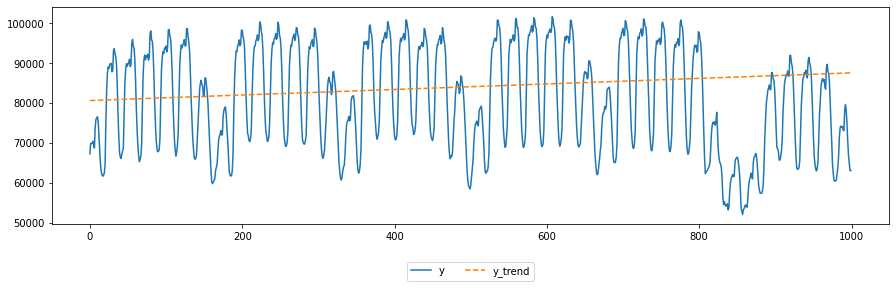

In [39]:
plt.figure(figsize=(15, 4))
plt.plot(y, label='y')
plt.plot(y_trend, linestyle='--', label='y_trend')

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()

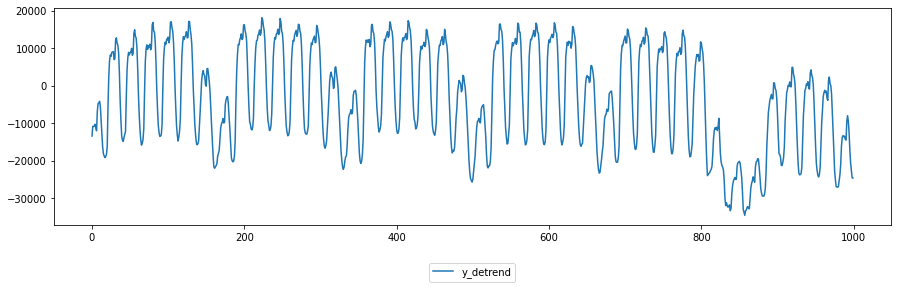

In [40]:
y_detrend = y - y_trend

plt.figure(figsize=(15, 4))
plt.plot(y_detrend, label='y_detrend')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()

3. Combine sequences

In [41]:
y_lbl = np.column_stack([y_detrend, x, [1]*train_len+[0]*(n-train_len)])

print(y_lbl.shape)
print(y_lbl)

(1000, 3)
[[-1.33700751e+04  0.00000000e+00  1.00000000e+00]
 [-1.08115217e+04  1.00000000e+00  1.00000000e+00]
 [-1.08133684e+04  2.00000000e+00  1.00000000e+00]
 ...
 [-2.26450120e+04  9.97000000e+02  0.00000000e+00]
 [-2.45322587e+04  9.98000000e+02  0.00000000e+00]
 [-2.45392053e+04  9.99000000e+02  0.00000000e+00]]


4. Normalize

In [42]:
y_train_max = y_lbl[y_lbl[:, 2]==1, :1].max(axis=0)
y_train_max = y_train_max.tolist()+[1]*2  # only normalize for the first column
print(y_train_max)

y_normalize = np.divide(y_lbl, y_train_max)
print(y_normalize)

[18164.91598103434, 1, 1]
[[-7.36038365e-01  0.00000000e+00  1.00000000e+00]
 [-5.95186994e-01  1.00000000e+00  1.00000000e+00]
 [-5.95288656e-01  2.00000000e+00  1.00000000e+00]
 ...
 [-1.24663456e+00  9.97000000e+02  0.00000000e+00]
 [-1.35052971e+00  9.98000000e+02  0.00000000e+00]
 [-1.35091213e+00  9.99000000e+02  0.00000000e+00]]


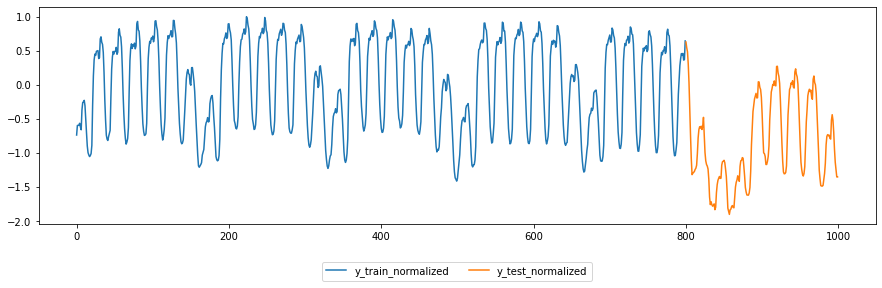

In [43]:
plt.figure(figsize=(15, 4))
plt.plot(range(train_len), y_normalize[:train_len, 0], label='y_train_normalized')
#plt.plot(range(train_len), y_normalize[:train_len, 1], label='trend_train_normalized')
plt.plot(range(train_len, len(y_normalize)), y_normalize[train_len:, 0], label='y_test_normalized')
#plt.plot(range(train_len, len(y_normalize)), y_normalize[train_len:, 1], label='trend_test_normalized')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()

5. Truncate

In [44]:
def truncate(x, feature_cols=range(2), target_cols=range(2), label_col=2, train_len=100, test_len=20):
    in_, out_, lbl = [], [], []
    for i in range(len(x)-train_len-test_len+1):
        in_.append(x[i:(i+train_len), feature_cols].tolist())
        out_.append(x[(i+train_len):(i+train_len+test_len), target_cols].tolist())
        lbl.append(x[i+train_len, label_col])
    return np.array(in_), np.array(out_), np.array(lbl)

X_in, X_out, lbl = truncate(y_normalize, feature_cols=range(2), target_cols=range(2), 
                            label_col=2, train_len=200, test_len=20)
print(X_in.shape, X_out.shape, lbl.shape)

(781, 200, 2) (781, 20, 2) (781,)


In [45]:
X_input_train = X_in[np.where(lbl==1)]
X_output_train = X_out[np.where(lbl==1)]
X_input_test = X_in[np.where(lbl==0)]
X_output_test = X_out[np.where(lbl==0)]
print(X_input_train.shape, X_output_train.shape)
print(X_input_test.shape, X_output_test.shape)

(600, 200, 2) (600, 20, 2)
(181, 200, 2) (181, 20, 2)


In [46]:
data = {
    'X_input_train': X_input_train, 
    'X_output_train': X_output_train, 
    'X_input_test': X_input_test, 
    'X_output_test': X_output_test,
    'X_trend': y_trend,
    'x_trend_param': y_trend_param,
    'x_train_max': y_train_max
         }


pkl.dump(data, open(f'../../Data/data{n}.pkl', 'wb'))